In [3]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

day = 67
v_lab = LabFuncs.LabVelocitySimple(day)

# Load VL2 data
vmax = 750.0
nbins = 50
h = zeros(shape=(200,nbins))
fdir = '../../../vl2data/bubbles/'
for i in range(0,200):
    VL2 = loadtxt(fdir+'bubble_1kpc_200_'+str(i+1)+'.dat')+v_lab
    vv = sqrt(sum(VL2**2.0,1))
    H = histogram(vv,nbins,range=(0.0,vmax),normed=True)
    h[i,:] = H[0]
vbins = H[1]

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.



In [5]:
# v range
n = 300
v = linspace(0.01,vmax,n)

# Halo params
v0 = 180.0
v_esc = 516.0
sig_beta = SHMpp.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)

# v range
n = 300
v = linspace(0.01,vmax,n)

v_esc = amax(vv)
sig_iso = array([1.0,1.0,1.0])*120

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)


# Smooth Speed distributions
fv_Iso = SpeedDist_Triaxial(v,day,sig_iso) # Galactic frame Halo
fv_Saus = SpeedDist_Triaxial(v,day,sig_beta) # Galactic frame Sausage
fv = zeros(shape=(nshards,n))
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv[i,:] = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,EscapeSpeed=False)

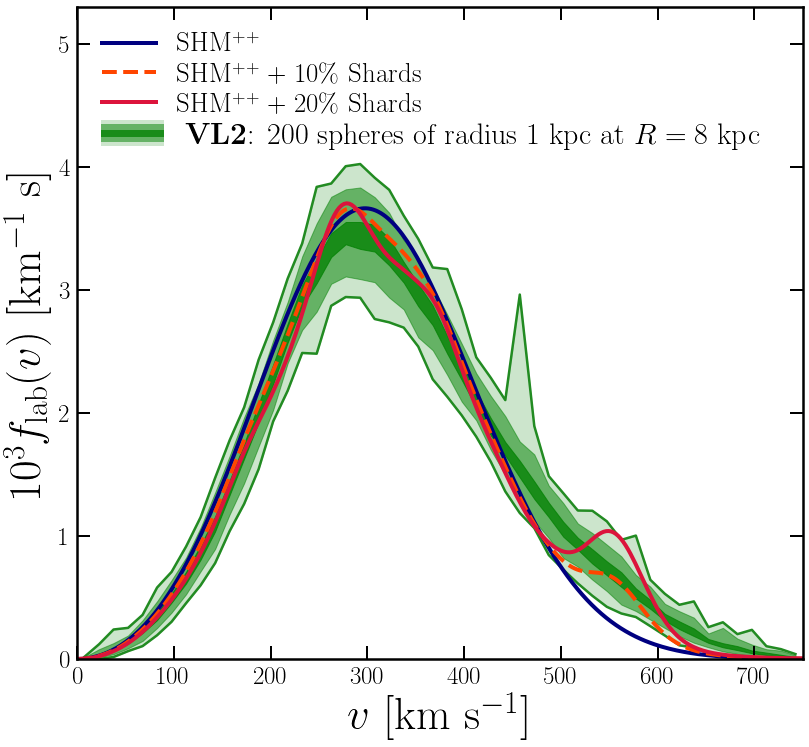

In [17]:
# Figure setup
xlab = r"$v$ [km s$^{-1}$]"
ylab = r"$10^3 f_{\rm lab}(v)$ [km$^{-1}$ s]"
fig,ax = MySquarePlot(xlab,ylab)

nhbins = 50
HH = zeros(shape=(nbins,nhbins))
h95 = zeros(shape=(nbins,2))
h68 = zeros(shape=(nbins,2))
htot = zeros(shape=(nbins,2))
hmin = 1.0/(1.0*nbins)
for i in range(0,nbins):
    H = histogram(h[:,i],nhbins,range=(0.0,5.0e-3))
    HH[i,:] = H[0]/(1.0*amax(H[0]))
    
    fvals = (sort(h[:,i]))
    hvals = cumsum(fvals)
    hvals = hvals/hvals[-1]
    htot[i,0] = fvals[hvals>0.0][0]
    h95[i,0] = fvals[hvals>0.05][0]
    h68[i,0] = fvals[hvals>0.32][0]
    h68[i,1]= fvals[hvals>0.68][0]
    h95[i,1] = fvals[hvals>0.95][0]
    htot[i,1] = fvals[hvals>=1.0][0]

hbins = H[1]

vc = vbins[0:-1]+vbins[1]/2.0

#plt.contourf(vc,1e3*(hbins[0:-1]+hbins[1]/2.0),HH.T,10,cmap=cm.Greens)
plt.fill_between(vc,1e3*htot[:,1],y2=1e3*htot[:,0],color='Green',alpha=0.2)
plt.fill_between(vc,1e3*h95[:,1],y2=1e3*h95[:,0],color='Green',alpha=0.5)
plt.fill_between(vc,1e3*h68[:,1],y2=1e3*h68[:,0],color='Green',alpha=0.75)
plt.fill_between([25,90],[4.38,4.38],y2=[4.17,4.17],color='Green',alpha=0.2,lw=0)
plt.fill_between([25,90],[4.35,4.35],y2=[4.2,4.2],color='Green',alpha=0.5,lw=0)
plt.fill_between([25,90],[4.3,4.3],y2=[4.24,4.24],color='Green',alpha=0.75,lw=0)

plt.plot(vc,1e3*amax(h,0),lw=2.5,color='ForestGreen')
plt.plot(vc,1e3*amin(h,0),lw=2.5,color='ForestGreen')

eta = 0.0
fv0 = (1-eta)*fv_Iso+eta*fv_Saus
plt.plot(v,1e3*fv0,'-',lw=4.0,color='Navy',label="SHM$^{++}$")
plt.plot(v,1e3*((1-0.1)*fv0+0.1*sum(fv,0)),'--',lw=4.0,color='orangered',label="SHM$^{++}$ + 10\% Shards")
plt.plot(v,1e3*((1-0.2)*fv0+0.2*sum(fv,0)),'-',lw=4.0,color='Crimson',label="SHM$^{++}$ + 20\% Shards")
plt.gcf().text(0.24,0.72,r'{\bf VL2}: 200 spheres of radius 1 kpc at $R=8$ kpc',fontsize=30)
leg = plt.legend(loc=2,frameon=False,fontsize=27,labelspacing=0.1)

# Plot fiddling
ax.set_xlim(left=0,right=vmax)
ax.set_ylim(bottom=0,top=5.3)


plt.show()
pltname = 'Shards_fv_wVL2'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [98]:
#### vl2

day = 67
v_lab = LabFuncs.LabVelocitySimple(day)

# Load VL2 data
fdir = '../../../vl2data/bubbles/'
nbins = 50
ddh_all = zeros(shape=(200,nbins))

nbins_l = 40
nbins_h = 60
ddh_all_l = zeros(shape=(200,nbins_l))
ddh_all_h = zeros(shape=(200,nbins_h))


for i in range(0,200):
    VL2 = loadtxt(fdir+'bubble_1kpc_200_'+str(i+1)+'.dat')+v_lab
    vv = sqrt(sum(VL2**2.0,1))
    H = histogram(vv,nbins,range=(0.0,vmax),normed=True)
    vbins = H[1]
    h1 = H[0]
    vc = vbins[0:-1]+vbins[1]/2.0
    dvc = vc[2]-vc[1]
    ddh = gradient(gradient(h1,dvc),dvc)
    ddh_all[i,:] = ddh
    #plt.plot(vc,ddh)
    #print i,'| bins=',size(vc),'N0c = ',NZeroCross(vc,ddh)
    
    
    H_l = histogram(vv,nbins_l,range=(0.0,vmax),normed=True)
    vbins_l = H_l[1]
    h1_l = H_l[0]
    vc_l = vbins_l[0:-1]+vbins_l[1]/2.0
    dvc_l = vc_l[2]-vc_l[1]
    ddh_l = gradient(gradient(h1_l,dvc_l),dvc_l)
    ddh_all_l[i,:] = ddh_l
    

    H_h = histogram(vv,nbins_h,range=(0.0,vmax),normed=True)
    vbins_h = H_h[1]
    h1_h = H_h[0]
    vc_h = vbins_h[0:-1]+vbins_h[1]/2.0
    dvc_h = vc_h[2]-vc_h[1]
    ddh_h = gradient(gradient(h1_h,dvc_h),dvc_h)
    ddh_all_h[i,:] = ddh_h


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


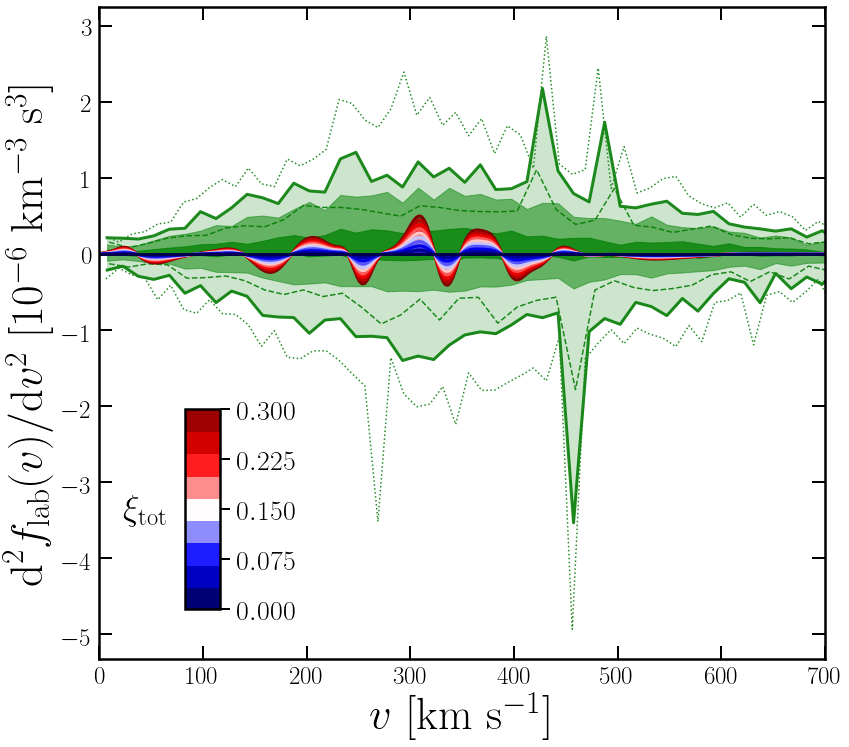

In [99]:
def NZeroCross(v1,ddf,vmax=700):
    ddf_sel = ddf[v1<vmax]
    dsign0 = abs(sign(ddf_sel[1:])-sign(ddf_sel[0:-1]))/2.0
    N0c = sum(dsign0>0)
    return N0c


# Figure setup
xlab = r"$v$ [km s$^{-1}$]"
ylab = r"$\textrm{d}^2f_{\rm lab}(v)/\textrm{d}v^2$ [$10^{-6}$ km$^{-3}$ s$^{3}$]"
fig,ax = MySquarePlot(xlab,ylab)


# VL2
h95 = zeros(shape=(nbins,2))
h68 = zeros(shape=(nbins,2))
htot = zeros(shape=(nbins,2))
hmin = 1.0/(1.0*nbins)
for i in range(0,nbins):
    fvals = (sort(ddh_all[:,i]))
    minf = amin(fvals)
    fvals -= minf
    hvals = cumsum(fvals)
    hvals = hvals/hvals[-1]
    htot[i,0] = fvals[hvals>=0.0][0]+minf
    h95[i,0] = fvals[hvals>0.05][0]+minf
    h68[i,0] = fvals[hvals>0.32][0]+minf
    h68[i,1]= fvals[hvals>0.68][0]+minf
    h95[i,1] = fvals[hvals>0.95][0]+minf
    htot[i,1] = fvals[hvals>=1.0][0]+minf

meanddh = mean(ddh_all,0)
plt.fill_between(vc,1e6*(htot[:,1]-meanddh),y2=1e6*(htot[:,0]-meanddh),color='Green',alpha=0.2)
plt.fill_between(vc,1e6*(h95[:,1]-meanddh),y2=1e6*(h95[:,0]-meanddh),color='Green',alpha=0.5)
plt.fill_between(vc,1e6*(h68[:,1]-meanddh),y2=1e6*(h68[:,0]-meanddh),color='Green',alpha=0.75)
#plt.fill_between([25,90],[4.38,4.38],y2=[4.17,4.17],color='Green',alpha=0.2,lw=0)
#plt.fill_between([25,90],[4.35,4.35],y2=[4.2,4.2],color='Green',alpha=0.5,lw=0)
#plt.fill_between([25,90],[4.3,4.3],y2=[4.24,4.24],color='Green',alpha=0.75,lw=0)
plt.plot(vc,1e6*(amax(ddh_all,0)-meanddh),'-',lw=3,color='ForestGreen',zorder=0)
plt.plot(vc,1e6*(amin(ddh_all,0)-meanddh),'-',lw=3,color='ForestGreen',zorder=0)

meanddh_l = mean(ddh_all_l,0)
plt.plot(vc_l,1e6*(amax(ddh_all_l,0)-meanddh_l),'--',lw=1.5,color='ForestGreen',zorder=0)
plt.plot(vc_l,1e6*(amin(ddh_all_l,0)-meanddh_l),'--',lw=1.5,color='ForestGreen',zorder=0)

meanddh_h = mean(ddh_all_h,0)
plt.plot(vc_h,1e6*(amax(ddh_all_h,0)-meanddh_h),':',lw=1.5,color='ForestGreen',zorder=0)
plt.plot(vc_h,1e6*(amin(ddh_all_h,0)-meanddh_h),':',lw=1.5,color='ForestGreen',zorder=0)


# SHM+Shards
dv = v[1]-v[0]
n_xi = 10
xi_max = 0.3
xi_vals = linspace(0.0,xi_max,n_xi)
col = (cm.seismic(linspace(0,1,n_xi)))
cmap = cm.seismic
eta = 0.2
fv0 = (1-eta)*fv_Iso + eta*fv_Saus
fvs = sum(fv,0)
ddfv0 = gradient(gradient(fv0,dv),dv)
ddfv1 = gradient(gradient((xi_vals[-1]*fvs+(1.0-xi_vals[-1])*fv0),dv),dv)

for j in range(0,n_xi):
    i = n_xi-j-1
    xi = xi_vals[i]
    ddfv = gradient(gradient(xi*fvs+(1-xi)*fv0,dv),dv)
    ax.fill_between(v,1e6*(ddfv-ddfv0),y2=0,color=col[i,:],alpha=0.5,zorder=1)
    ax.plot(v,1e6*(ddfv-ddfv0),'-',color=col[i,:],linewidth=3,zorder=2)
    
#plt.plot(v,1e6*(ddfv1-ddfv0),'-',color=col[-1,:],lw=3)
#plt.plot(v,1e6*(ddfv0-ddfv0),'-',color=col[0,:],lw=3)

#print 'xi=0 :','N0c = ',NZeroCross(v,ddfv0)
#print 'xi=1 :','N0c = ',NZeroCross(v,ddfv1)
   


# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-450, -30, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=xi_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=linspace(0,xi_max,5),boundaries=linspace(0,xi_max,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.15,0.28,r'$\xi_{\rm tot}$',fontsize=35,color='k')

ax.set_xlim([0,700])
plt.show()

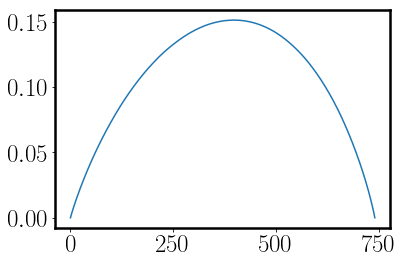

In [106]:
ns = size(vv)
plt.plot(linspace(0,max(vv),ns),linspace(0,1.0,ns)-cumsum(sort(vv))/sum(vv))

plt.plot()
plt.show()

In [170]:
nbins = 100
cumh = zeros(shape=(200,nbins))
hsum = zeros(shape=nbins+1)
for i in range(0,200):
    VL2 = loadtxt(fdir+'bubble_1kpc_200_'+str(i+1)+'.dat')+v_lab
    vv = sqrt(sum(VL2**2.0,1))
    H = histogram(vv,nbins+1,range=(0.0,vmax),normed=True)
    vbins = H[1]
    h1 = H[0]
    vc = vbins[0:-1]+vbins[1]/2.0
    cumh[i,:] = cumtrapz(h1,vc)
    hsum += h1
    


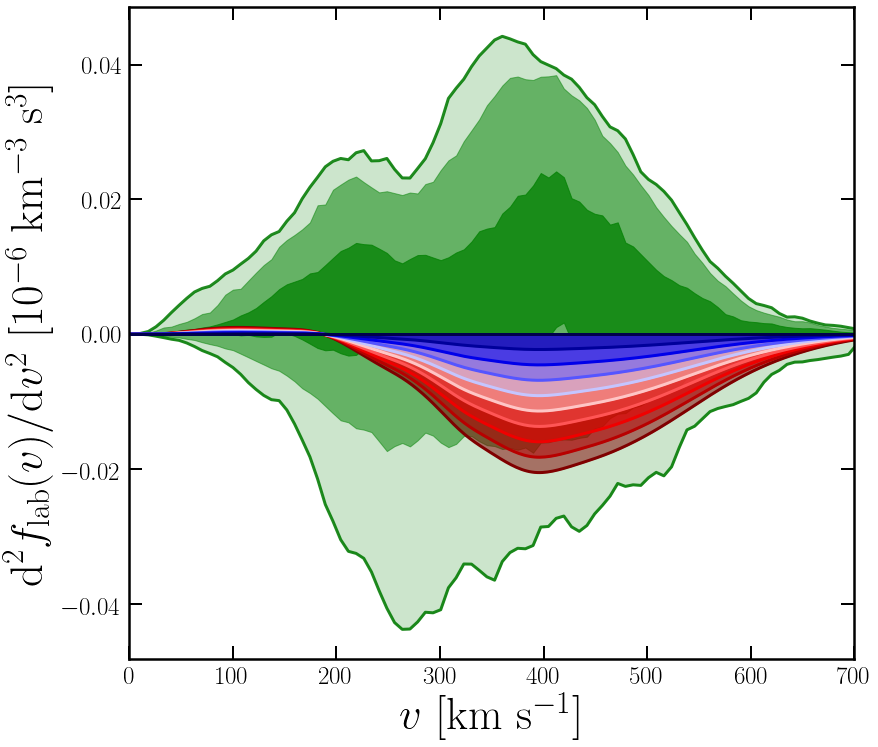

In [174]:
# Figure setup
xlab = r"$v$ [km s$^{-1}$]"
ylab = r"$\textrm{d}^2f_{\rm lab}(v)/\textrm{d}v^2$ [$10^{-6}$ km$^{-3}$ s$^{3}$]"
fig,ax = MySquarePlot(xlab,ylab)


cumh_med = cumtrapz(hsum,vc)
cumh_med /= cumh_med[-1]
cum_diff = zeros(shape=(200,nbins))
for i in range(0,200):
    cum_diff[i,:] =  cumh[i,:]-cumh_med
    
# VL2
h95 = zeros(shape=(nbins,2))
h68 = zeros(shape=(nbins,2))
htot = zeros(shape=(nbins,2))
hmin = 1.0/(1.0*nbins)
for i in range(0,nbins):
    fvals = (sort(cum_diff[:,i]))
    minf = amin(fvals)
    fvals -= minf
    hvals = cumsum(fvals)
    hvals = hvals/hvals[-1]
    htot[i,0] = fvals[hvals>=0.0][0]+minf
    h95[i,0] = fvals[hvals>0.05][0]+minf
    h68[i,0] = fvals[hvals>0.32][0]+minf
    h68[i,1]= fvals[hvals>0.68][0]+minf
    h95[i,1] = fvals[hvals>0.95][0]+minf
    htot[i,1] = fvals[hvals>=1.0][0]+minf

plt.fill_between(vc[1:],htot[:,1],y2=htot[:,0],color='Green',alpha=0.2)
plt.fill_between(vc[1:],h95[:,1],y2=h95[:,0],color='Green',alpha=0.5)
plt.fill_between(vc[1:],h68[:,1],y2=h68[:,0],color='Green',alpha=0.75)
plt.plot(vc[1:],amax(cum_diff,0),'-',lw=3,color='ForestGreen',zorder=0)
plt.plot(vc[1:],amin(cum_diff,0),'-',lw=3,color='ForestGreen',zorder=0)   
    
    
    
cumf0 = cumtrapz(fv0,v)
n_xi = 10
xi_max = 0.1
xi_vals = linspace(0.0,xi_max,n_xi)
col = (cm.seismic(linspace(0,1,n_xi)))
cmap = cm.seismic
for j in range(0,n_xi):
    i = n_xi-j-1
    xi = xi_vals[i]
    cumf1 = cumtrapz((1-xi)*fv0+xi*fvs,v)
    ax.fill_between(v[1:],cumf1-cumf0,y2=0,color=col[i,:],alpha=0.5,zorder=1)
    ax.plot(v[1:],cumf1-cumf0,'-',color=col[i,:],linewidth=3,zorder=2)

ax.set_xlim([0,700])
plt.show()

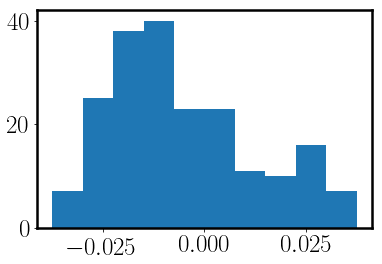

In [167]:
plt.hist(cumh[:,50]-(amax(cumh[:,50])+amin(cumh[:,50]))/2.0)
plt.show()